# ML for AIR

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from autots import AutoTS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
#from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
path = r"D:\OneDrive - Wipro\Desktop\AIR\\"
infile =  path + "AIR_WDC_today_Q1Q2Q3.csv"

#r"D:\OneDrive - Wipro\Desktop\AIR\AIR_WDC_today_Q1Q2Q3.csv"

#table = pd.read_csv(infile, engine='python',sep=',', quotechar='"', error_bad_lines=False)

table_chunk = pd.read_csv(infile, engine='python', sep=',', chunksize=2000000)
table = pd.concat(list(table_chunk))

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

table.head()

,LOAD_DATE,SR_GUID,PROJECT_NUMBER,PROJECT_NAME,PROJECT_DESCRIPTION,CUSTOMER_NO,CUSTOMER_NAME,INDENT_STATUS,PROJECT_PROFIT_CENTER,PROJECT_PROFIT_CENTER_DESCRIPTION,...,SL_OPS_PC_DESC,SL_OPS_SERVICE_LINE,SLWBS,REPORT_TIME,SL_OPS_GBL,SL_DM_ID,SL_DM_NAME,SL_PM_ID,SL_PM_NAME,SOW_OWNER_EMAIL
0,2025-03-08,037817F5F7F91EEEBC836BD174C8E955,358149.0,49722/DG/P05/B47/S50,ANZ-RLA-AMS- Support1,31004.0,RESOLUTION LIFE SERVICES AUSTRALIA,RECRUIT,PC36400,APMEA,...,WIPRO FULLSTRIDE CLOUD,FSC - WDC,49722/P05/B47/SL02,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-08,037817F5F7F91EEEBC984EDC9427AA55,399689.0,27266/P05/B05/S80,E2E Testing consolidation,26555.0,T-Mobile USA Inc.,RECRUIT,PC30200,AMERICAS 1,...,NaN,NaN,NaN,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-08,037817F5F7F91EEEBC9EFC3DDF02AA58,307434.0,37456/DG/P03/B02/S80,Assurance Main,10761.0,Aviva Life Services UK Limited,INTERNAL,PC34100,EUROPE,...,NaN,NaN,NaN,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-08,037817F5F7F91EEF84AD5879362E0CC4,433386.0,WBS120240418134724,Care Solution 2024-2026,11237.0,"United HealthCare Services, Inc.",INTERNAL,PC30100,AMERICAS 1,...,WIPRO FULLSTRIDE CLOUD,FSC - WDC,39808/P05/B02/SL04,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-08,037817F5F7F91EEEBC9CE64239CFAA58,221717.0,17990/P03/B02/S35,CIMIC_T&M_2022-2023_AppDev,71276.0,CIMIC GROUP LTD,INTERNAL,PC36400,APMEA,...,WIPRO FULLSTRIDE CLOUD,FSC - WDC,17990/P03/B02/SL03,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
table.describe()

,PROJECT_NUMBER,CUSTOMER_NO,TM_ID,PM_ID,NO_OF_RESOURCES,PROPOSED,ALLOCATED,OPEN_POS,IFP_EMP_NO,ROLE_ID,...,EMP_NO,P2P_R2R_IND_FL,TOTAL_MTE_OPENINGS,TOTAL_MTE_ALLOCATED,TOTAL_INTERNAL_OPENINGS,TOTAL_INTERNAL_ALLOCATED,ZMTE_APPROVED_ON,SR_BILLABILITY_PERCENTAGE,SL_DM_ID,SL_PM_ID
count,22221.000000,2.176300e+04,2.222100e+04,2.222100e+04,22221.000000,22221.000000,22221.000000,22221.000000,2.222100e+04,22221.000000,...,2.222100e+04,0.0,22221.000000,22221.000000,22221.000000,22221.000000,2.222100e+04,22221.000000,4.714000e+03,4.714000e+03
mean,414568.510328,6.918722e+07,5.562007e+06,7.848556e+06,1.338869,2.100941,0.092615,0.060753,2.164959e+06,574.135997,...,1.511736e+06,NaN,0.723955,0.055398,0.614914,0.037217,1.012920e+07,99.842779,6.206491e+06,8.677394e+06
std,137016.841770,2.668806e+08,8.837133e+06,9.581971e+06,1.511020,4.393876,0.366424,0.420983,5.790074e+06,634.575740,...,5.903211e+06,NaN,1.111893,0.256228,1.281907,0.263623,1.012077e+07,3.090631,9.139299e+06,9.993473e+06
min,40981.000000,2.900000e+01,0.000000e+00,1.296000e+04,1.000000,0.000000,0.000000,-2.000000,0.000000e+00,19.000000,...,0.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,7.100000,1.438200e+04,6.706600e+04
25%,363978.000000,5.766000e+03,1.221260e+05,3.001090e+05,1.000000,0.000000,0.000000,0.000000,1.001900e+05,115.000000,...,0.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,100.000000,1.400360e+05,3.557830e+05
50%,425937.000000,1.553100e+04,2.104810e+05,8.101910e+05,1.000000,1.000000,0.000000,0.000000,2.621010e+05,159.000000,...,0.000000e+00,NaN,1.000000,0.000000,0.000000,0.000000,2.024040e+07,100.000000,2.787750e+05,7.879295e+05
75%,451405.000000,7.014600e+04,2.005445e+07,2.014283e+07,1.000000,3.000000,0.000000,0.000000,5.500510e+05,1444.000000,...,0.000000e+00,NaN,1.000000,0.000000,1.000000,0.000000,2.024082e+07,100.000000,2.014708e+07,2.021049e+07
max,638367.000000,1.100045e+09,2.055201e+07,4.013274e+07,60.000000,140.000000,17.000000,15.000000,2.052723e+07,4391.000000,...,4.017224e+07,NaN,45.000000,7.000000,60.000000,17.000000,2.025022e+07,100.000000,2.055201e+07,4.013274e+07


In [3]:
df = table[['INDENT_CREATED_ON','ESSENTIAL_SKILL','NO_OF_RESOURCES','INDENT_STATE']]

In [4]:
df.head()

,INDENT_CREATED_ON,ESSENTIAL_SKILL,NO_OF_RESOURCES,INDENT_STATE
0,2024-04-01,Micro Focus COBOL,1,CANCELLED
1,2024-04-02,SAP Test Management,1,CANCELLED
2,2024-04-02,Selenium,1,CANCELLED
3,2024-05-14,Project Management,1,CANCELLED
4,2024-04-02,.NET,1,CANCELLED


In [5]:
df.describe()

,NO_OF_RESOURCES
count,22221.000000
mean,1.338869
std,1.511020
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,60.000000


In [4]:
df.rename(columns={'INDENT_CREATED_ON': 'Date'}, inplace=True)
df.rename(columns={'NO_OF_RESOURCES': 'Total'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22221 entries, 0 to 22220
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             22221 non-null  object
 1   ESSENTIAL_SKILL  22221 non-null  object
 2   Total            22221 non-null  int64 
 3   INDENT_STATE     22221 non-null  object
dtypes: int64(1), object(3)
memory usage: 694.5+ KB


In [ ]:
df.head()

In [79]:
df['Date'] = pd.to_datetime(df.Date)
#df.head()
#meandf = df['Total'].mean(skipna=True)
#df=df.replace(0,meandf) 
#df['Total'] = df['Total'].replace(['0'],np.average(df['Total']))
df.head()

,Date,ESSENTIAL_SKILL,Total,INDENT_STATE
0,2024-04-01,Micro Focus COBOL,1,CANCELLED
1,2024-04-02,SAP Test Management,1,CANCELLED
2,2024-04-02,Selenium,1,CANCELLED
3,2024-05-14,Project Management,1,CANCELLED
4,2024-04-02,.NET,1,CANCELLED


In [80]:
tmpdf = df[df['ESSENTIAL_SKILL'] == '.NET']

In [81]:
tmpdf

,Date,ESSENTIAL_SKILL,Total,INDENT_STATE
4,2024-04-02,.NET,1,CANCELLED
7,2024-05-28,.NET,1,CANCELLED
17,2024-04-23,.NET,2,CANCELLED
24,2024-04-10,.NET,1,CANCELLED
30,2024-04-10,.NET,2,FULFILLED
...,...,...,...,...
22065,2024-12-18,.NET,1,FULFILLED
22069,2024-12-19,.NET,1,PENDING
22083,2024-10-14,.NET,2,PENDING
22106,2024-11-12,.NET,3,PENDING


In [82]:
tmpdf.set_index('Date',inplace=True)
tmpdf.index

DatetimeIndex(['2024-04-02', '2024-05-28', '2024-04-23', '2024-04-10',
               '2024-04-10', '2024-04-10', '2024-05-07', '2024-04-18',
               '2024-05-07', '2024-04-22',
               ...
               '2024-11-13', '2024-11-15', '2024-12-19', '2024-10-18',
               '2024-12-13', '2024-12-18', '2024-12-19', '2024-10-14',
               '2024-11-12', '2024-11-13'],
              dtype='datetime64[ns]', name='Date', length=980, freq=None)

In [67]:
df.asfreq('d').index # Setting the freq of series to Daily 'd'

DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', freq='D')

In [84]:
tmpdf = tmpdf.groupby("Date").sum()

In [85]:
tmpdf = tmpdf.sort_index()
tmpdf = tmpdf['2024-04-01':'2025-12-31'].resample('D').sum()

In [86]:
tdf = tmpdf[['Total']] # copy of Dataframe
tdf1 = tdf.rolling(window=7).mean().fillna(method='bfill') #type: ignore

In [ ]:
""" tdf.rolling(window=7).mean()
tdf.dropna()
tdf """

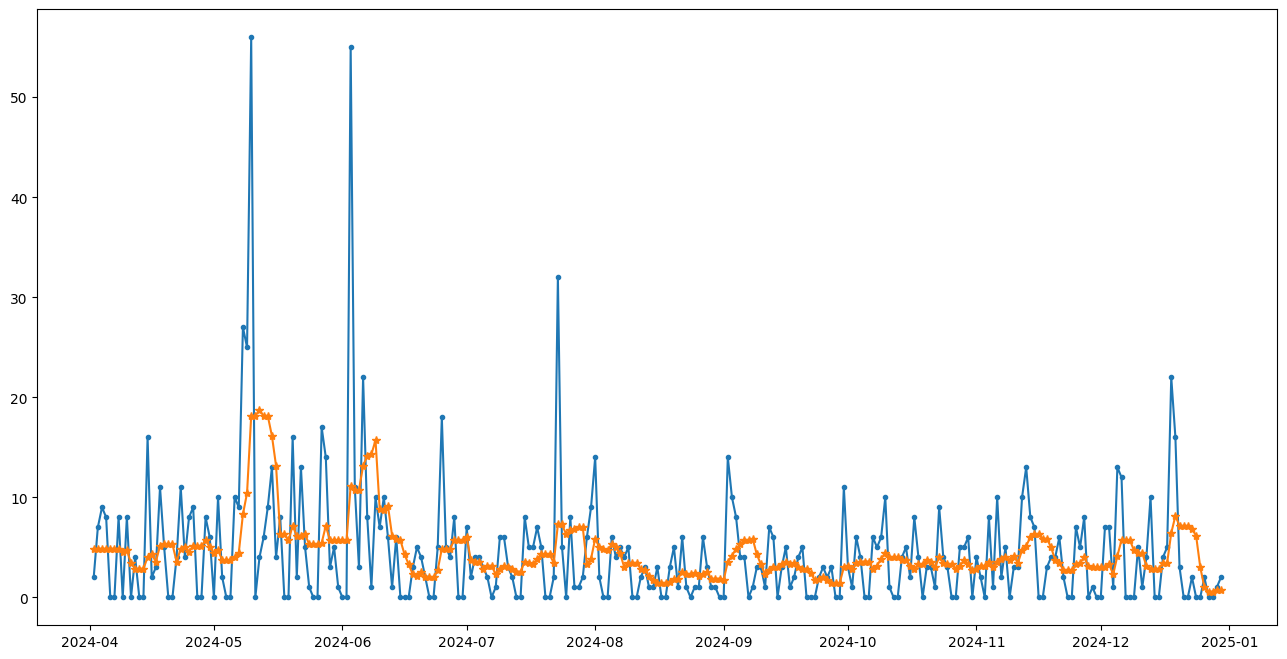

In [87]:
plt.figure(figsize=(16,8))
plt.plot(tdf, label='Open Position Trend', marker='.')
plt.plot(tdf1, marker='*')

In [37]:
def add_features(af):
    af['MA7'] = af['Total'].rolling(window=7).mean()
    af['MA30'] = af['Total'].rolling(window=30).mean()
    af['STD7'] = af['Total'].rolling(window=7).std()
    return af

In [89]:
tdf = add_features(tdf)
tdf[["Total","MA7","MA30","STD7"]]

,Total,MA7,MA30,STD7
Date,,,,
2024-04-02,2,NaN,NaN,NaN
2024-04-03,7,NaN,NaN,NaN
2024-04-04,9,NaN,NaN,NaN
2024-04-05,8,NaN,NaN,NaN
2024-04-06,0,NaN,NaN,NaN
...,...,...,...,...
2024-12-26,2,1.000000,4.100000,1.290994
2024-12-27,0,0.571429,3.833333,0.975900
2024-12-28,0,0.571429,3.833333,0.975900


In [ ]:
tdf.to_csv("Selenium.csv")

In [39]:
# Prepare features and target
def prepare_data(df, lookback=30):
    X = []
    y = []
    for i in range(len(df)-lookback):
        X.append(df[i:(i+lookback)])
        y.append(df[i+lookback])
    return np.array(X), np.array(y)

In [90]:
tdf1 = tdf['Total']
tdf1

Date
2024-04-02    2
2024-04-03    7
2024-04-04    9
2024-04-05    8
2024-04-06    0
             ..
2024-12-26    2
2024-12-27    0
2024-12-28    0
2024-12-29    1
2024-12-30    2
Freq: D, Name: Total, Length: 273, dtype: int64

In [41]:
# Convert your time series data
X, y = prepare_data(tdf1.values)

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((170, 30), (73, 30), (170,), (73,))

In [44]:

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'GaussianNB': GaussianNB(var_smoothing=1e-3)
    
}

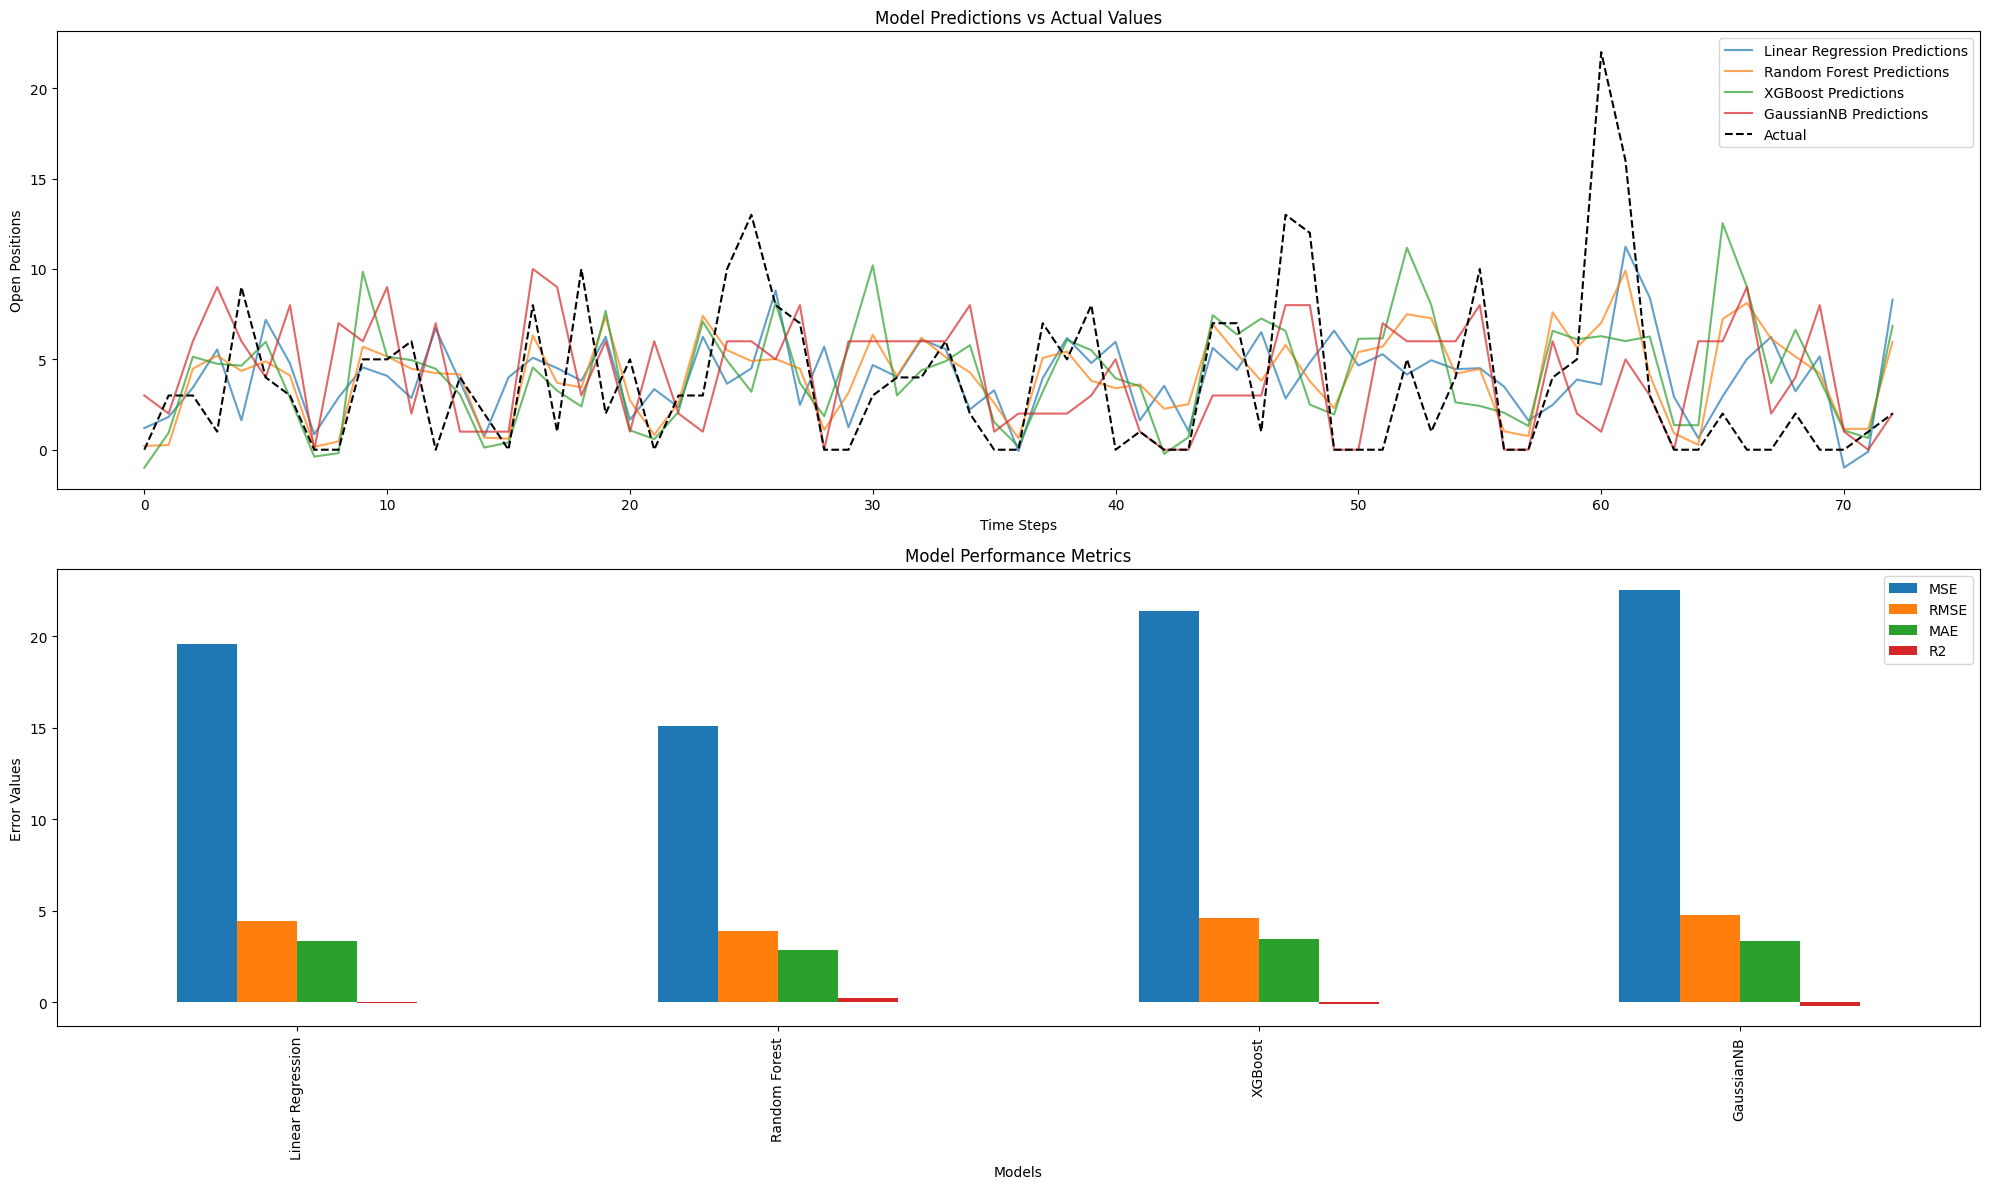

In [46]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate errors
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Plot actual vs predicted for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    ax1.plot(y_pred, label=f'{name} Predictions', alpha=0.7)

ax1.plot(y_test, label='Actual', color='black', linestyle='--')
ax1.set_title('Model Predictions vs Actual Values')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Open Positions')
ax1.legend()

# Plot error metrics
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', ax=ax2)
ax2.set_title('Model Performance Metrics')
ax2.set_xlabel('Models')
ax2.set_ylabel('Error Values')
plt.tight_layout()
plt.show()

In [47]:
# Print detailed results
print("\nDetailed Model Performance Metrics:")
print(pd.DataFrame(results).round(4))


Detailed Model Performance Metrics:
      Linear Regression  Random Forest  XGBoost  GaussianNB
MSE             19.5456        15.0875  21.3661     22.5205
RMSE             4.4210         3.8843   4.6223      4.7456
MAE              3.3162         2.8752   3.4305      3.3699
R2              -0.0276         0.2068  -0.1233     -0.1840


In [48]:
forecast_period = 6
def forecast_next_n_months(model, last_sequence, n_steps=forecast_period):
    """
    Forecast the next n months using the trained model
    
    Parameters:
    model: trained model
    last_sequence: last known sequence of data
    n_steps: number of steps to forecast (n months)
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Reshape sequence for prediction
        current_input = current_sequence.reshape(1, -1)
        # Get prediction for next step
        next_pred = model.predict(current_input)[0]
        # Add prediction to results
        predictions.append(next_pred)
        # Update sequence by removing first element and adding prediction
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    return np.array(predictions)


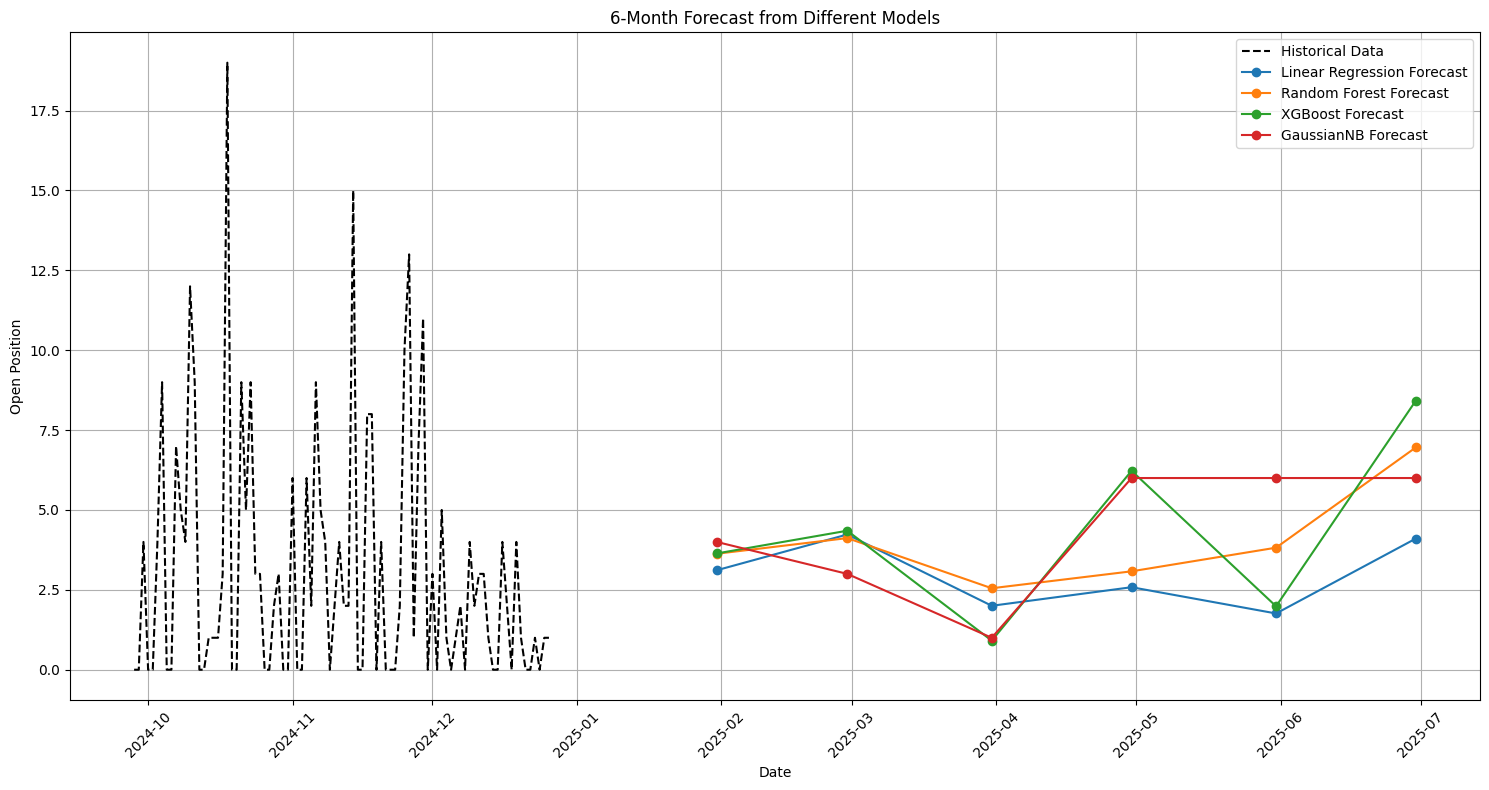


Forecasted values for next 6 months:
            Linear Regression  Random Forest  XGBoost  GaussianNB
2025-01-31               3.11           3.63     3.64           4
2025-02-28               4.23           4.12     4.35           3
2025-03-31               2.00           2.55     0.91           1
2025-04-30               2.58           3.08     6.23           6
2025-05-31               1.76           3.82     1.99           6
2025-06-30               4.11           6.96     8.43           6


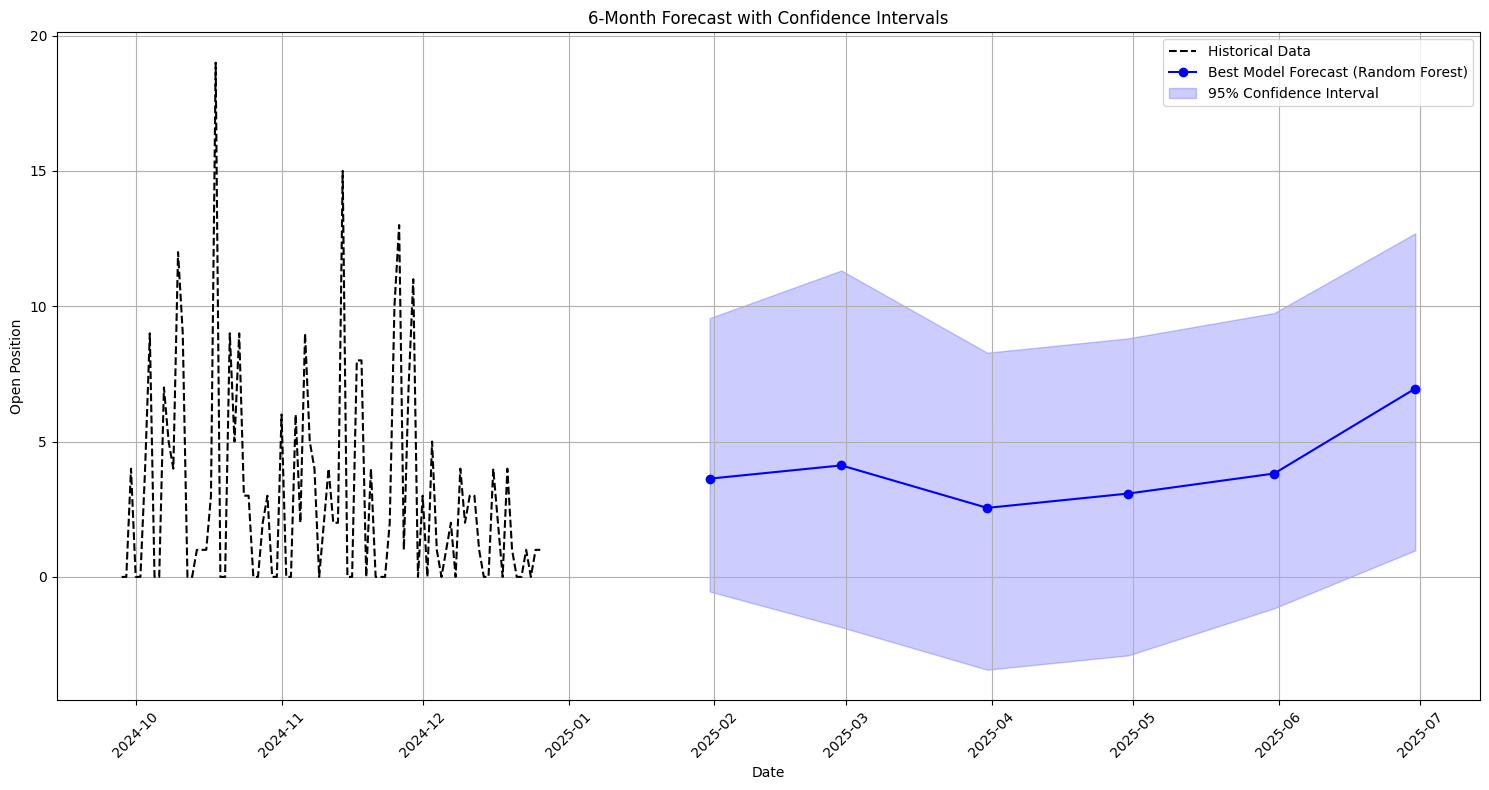


Best Model (Random Forest) Forecast with 95% Confidence Intervals:
            Forecast  Lower CI  Upper CI
2025-01-31      3.63     -0.54      9.56
2025-02-28      4.12     -1.86     11.32
2025-03-31      2.55     -3.43      8.28
2025-04-30      3.08     -2.90      8.81
2025-05-31      3.82     -1.16      9.75
2025-06-30      6.96      0.98     12.69


In [63]:
# Get the last sequence from your training data
last_known_sequence = X[-1]

# Create dictionary to store forecasts from different models
forecasts = {}

# Generate forecasts for each model
for name, model in models.items():
    future_predictions = forecast_next_n_months(model, last_known_sequence)
    forecasts[name] = future_predictions

# Create future dates for plotting
last_date = tmpdf.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_period + 1, freq='M')[1:]

# Visualize the forecasts
plt.figure(figsize=(15, 8))
# Plot historical data
plt.plot(tmpdf.index[-90:], tmpdf['Total'].values[-90:], 
         label='Historical Data', color='black', linestyle='--')

# Plot forecasts from each model
for name, forecast in forecasts.items():
    plt.plot(future_dates, forecast, label=f'{name} Forecast', marker='o')

plt.title(f'{forecast_period}-Month Forecast from Different Models')
plt.xlabel('Date')
plt.ylabel('Open Position')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a DataFrame with the forecasts
forecast_df = pd.DataFrame(forecasts, index=future_dates)
print(f"\nForecasted values for next {forecast_period} months:")
print(forecast_df.round(2))

# Calculate confidence intervals for the best performing model
# Using the model with lowest RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_forecast = forecasts[best_model_name]

# Bootstrap to calculate confidence intervals
n_bootstrap = 1000
bootstrap_predictions = np.zeros((n_bootstrap, forecast_period))

for i in range(n_bootstrap):
    # Sample with replacement from the training error distribution
    train_predictions = models[best_model_name].predict(X_train)
    error_distribution = y_train - train_predictions
    sampled_errors = np.random.choice(error_distribution, size=forecast_period)
    bootstrap_predictions[i] = best_forecast + sampled_errors

# Calculate 95% confidence intervals
lower_ci = np.percentile(bootstrap_predictions, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_predictions, 97.5, axis=0)

# Plot forecast with confidence intervals
plt.figure(figsize=(15, 8))
plt.plot(tmpdf.index[-90:], tmpdf['Total'].values[-90:], 
         label='Historical Data', color='black', linestyle='--')
plt.plot(future_dates, best_forecast, 
         label=f'Best Model Forecast ({best_model_name})', color='blue', marker='o')
plt.fill_between(future_dates, lower_ci, upper_ci, 
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title(f'{forecast_period}-Month Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Open Position')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecast with confidence intervals
print(f"\nBest Model ({best_model_name}) Forecast with 95% Confidence Intervals:")
ci_df = pd.DataFrame({
    'Forecast': best_forecast,
    'Lower CI': lower_ci,
    'Upper CI': upper_ci
}, index=future_dates)
print(ci_df.round(2))

In [ ]:
model_list = [
    'LastValueNaive',
    'GLS',
    'ETS',
    'ARIMA',
    'AverageValueNaive',
    'SeasonalNaive',
]

In [96]:
model = AutoTS(
    forecast_length=30,
    frequency='D',
    prediction_interval=0.95,
    ensemble=None, # type: ignore
    models_mode='deep',
    model_list = model_list,
    max_generations=10,
    num_validations=3,
    no_negatives=True,
    n_jobs='auto') # type: ignore

Using 10 cpus for n_jobs.


In [91]:
tdf

,Total,MA7,MA30,STD7
Date,,,,
2024-04-02,2,NaN,NaN,NaN
2024-04-03,7,NaN,NaN,NaN
2024-04-04,9,NaN,NaN,NaN
2024-04-05,8,NaN,NaN,NaN
2024-04-06,0,NaN,NaN,NaN
...,...,...,...,...
2024-12-26,2,1.000000,4.100000,1.290994
2024-12-27,0,0.571429,3.833333,0.975900
2024-12-28,0,0.571429,3.833333,0.975900


In [ ]:
model.fit(tdf) #type: ignore
prediction = model.predict(forecast_length=30) #type: ignore

In [55]:
#exporting the model trained on data
model.export_template(
    "Selenium.csv",
    models="best",
    max_per_model_class=1,
    include_results=True,
) # type: ignore

In [ ]:
#declare the AutoTS object "model" first
model = model.import_template(
    "Selenium.csv",
    method="only",
    enforce_model_list=True
)
model.fit(tdf) # type: ignore
prediction = model.predict(forecast_length=10) # type: ignore

In [98]:
best_model = model.best_model #type: ignore
best_model_name = model.best_model_name #type: ignore
best_model_params = model.best_model_params #type: ignore

# Print model details
print(f"Best Model: {best_model_name}")
print(f"Best Model Parameters: {best_model_params}")

Best Model: ETS
Best Model Parameters: {'damped_trend': False, 'trend': 'additive', 'seasonal': 'additive', 'seasonal_periods': 7, 'method': 'SLSQP'}


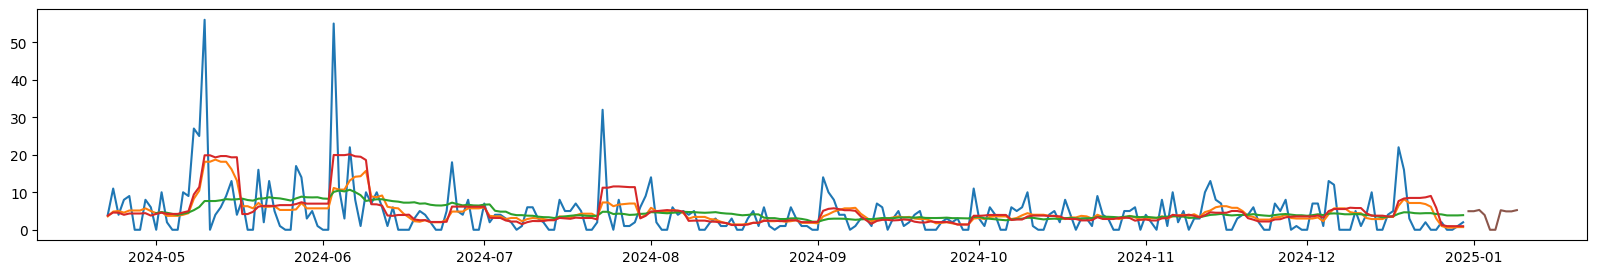

In [133]:
fig,ax = plt.subplots(figsize=(20,3))
ax.plot(tdf[20:])
ax.plot(prediction.forecast['Total']) # type: ignore

In [146]:
prediction.forecast['Total']

2024-12-31    4.954697
2025-01-01    4.954712
2025-01-02    5.288018
2025-01-03    3.929044
2025-01-04    0.000000
2025-01-05    0.000000
2025-01-06    5.211157
2025-01-07    4.908347
2025-01-08    4.908362
2025-01-09    5.241668
Freq: D, Name: Total, dtype: float64

In [147]:
future_dates = prediction.forecast.asfreq('d').index 

In [148]:

# Create a new DataFrame for predictions
predictions_df = pd.DataFrame(predf, index=future_dates, columns=['Predictions'])
predictions_df

,Predictions
2024-12-31,NaN
2025-01-01,NaN
2025-01-02,NaN
2025-01-03,NaN
2025-01-04,NaN
2025-01-05,NaN
2025-01-06,NaN
2025-01-07,NaN
2025-01-08,NaN
2025-01-09,NaN


In [152]:
# Concatenate the original DataFrame with predictions
tmpdf = pd.concat([tmpdf, predictions_df],axis=1)

# Sort the index to ensure chronological order
tmpdf.sort_index(inplace=True)

In [153]:
tmpdf.to_csv(".NetForecast.csv")

In [50]:
# Fit auto_arima model
auto_model = pm.auto_arima(tdf, 
                           seasonal=True, m=12, 
                           trace=True, error_action='ignore', 
                           suppress_warnings=True,
                           scoring='mse',
                        #    start_p=0,start_q=0,
                        #    max_p=5,
                        #    max_q=5,
                        #    max_P=2, 
                        #    max_Q=2,
                        #    max_order=5,
                           n_jobs=-1,
                           test='adf',
                           n_fits=50)

# Print the summary of the model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1804.871, Time=7.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1806.168, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1798.701, Time=1.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1799.000, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1911.098, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1796.701, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1798.701, Time=0.97 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1799.856, Time=2.55 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1798.695, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1798.691, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1797.010, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1798.777, Time=2.00 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=1847.924, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 15.888 seconds
       

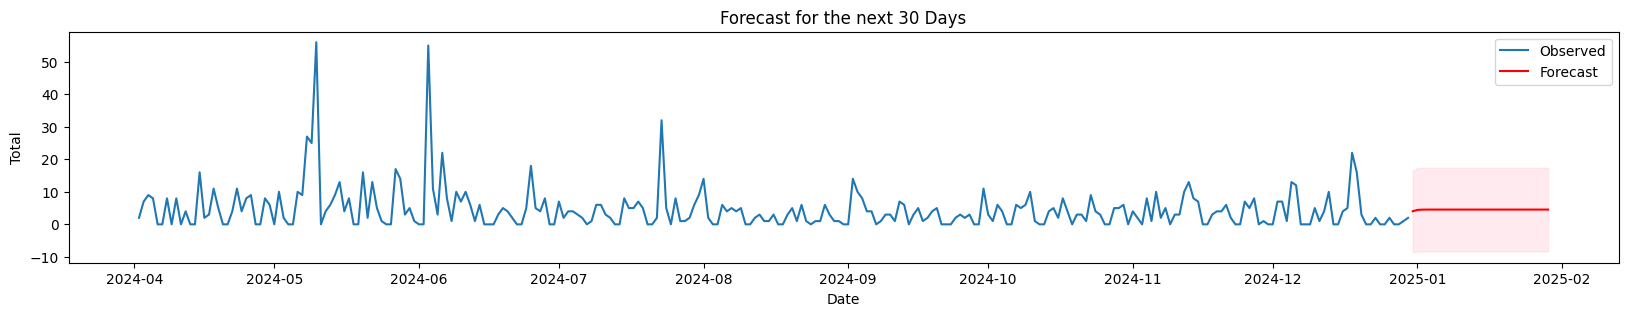

In [53]:
# Predict for the next 3 months (approximately 90 days)
n_periods = 30
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Create a date range for the forecast
forecast_index = pd.date_range(start=tdf.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')

# Create a DataFrame to hold the forecast and confidence intervals
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

forecast_df.to_csv("predict.csv")

# Plot the forecast
fig,ax = plt.subplots(figsize=(20,3))
#plt.figure(figsize=(16, 8))
plt.plot(tdf, label='Observed')
plt.plot(forecast_df['Forecast'], label='Forecast', color='r')
#ax.plot(prediction.forecast)
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Forecast for the next 30 Days')
plt.legend()
plt.show()

In [54]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(timeseries, period = int(len(tdf)/2), model = "additive")  
#figure = plt.figure()  
#figure = decomposition.plot()  
#figure.set_size_inches(15, 8
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model ='additive',extrapolate_trend='freq', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(24,8)
    plt.show()

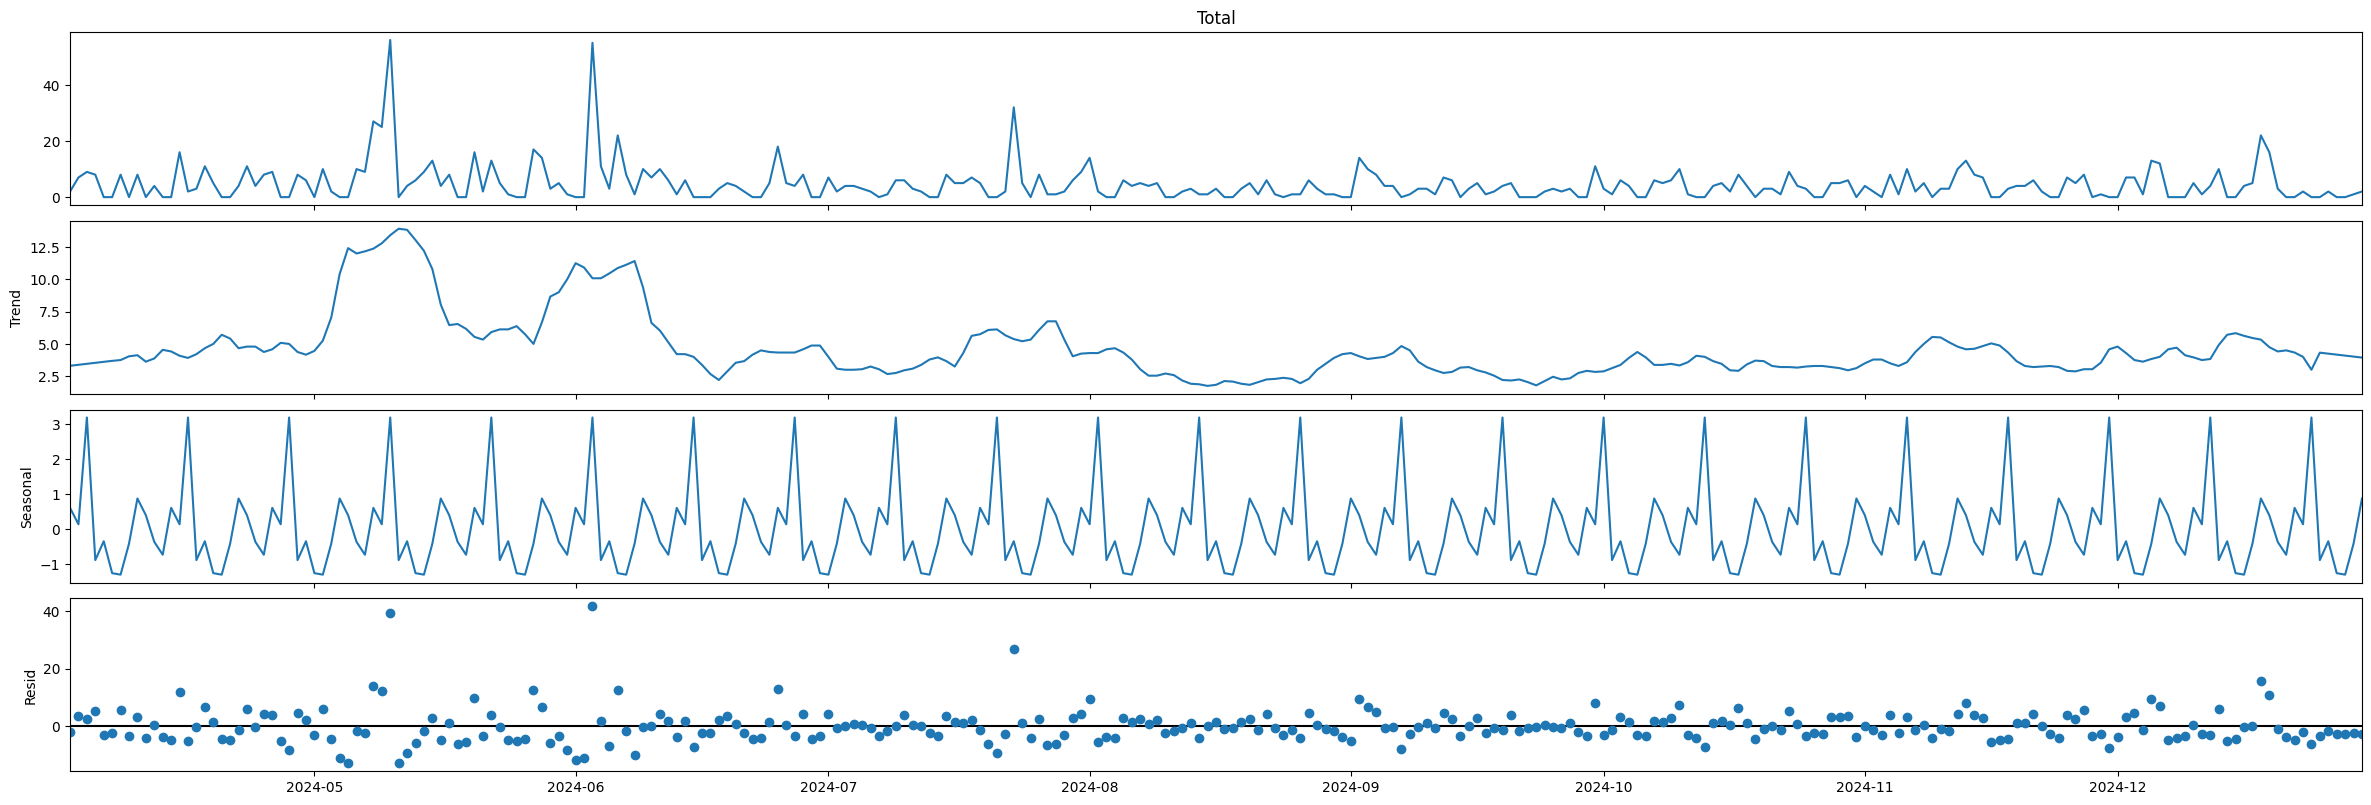

In [55]:
seasonal_decompose(tdf)

In [56]:
#plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    timeseries.rolling(4).mean().plot(label='4 Weeks Rolling Mean')
    timeseries.rolling(8).std().plot(label='8 Weeks Rolling Std')
    timeseries.plot(title=title)
    plt.legend()

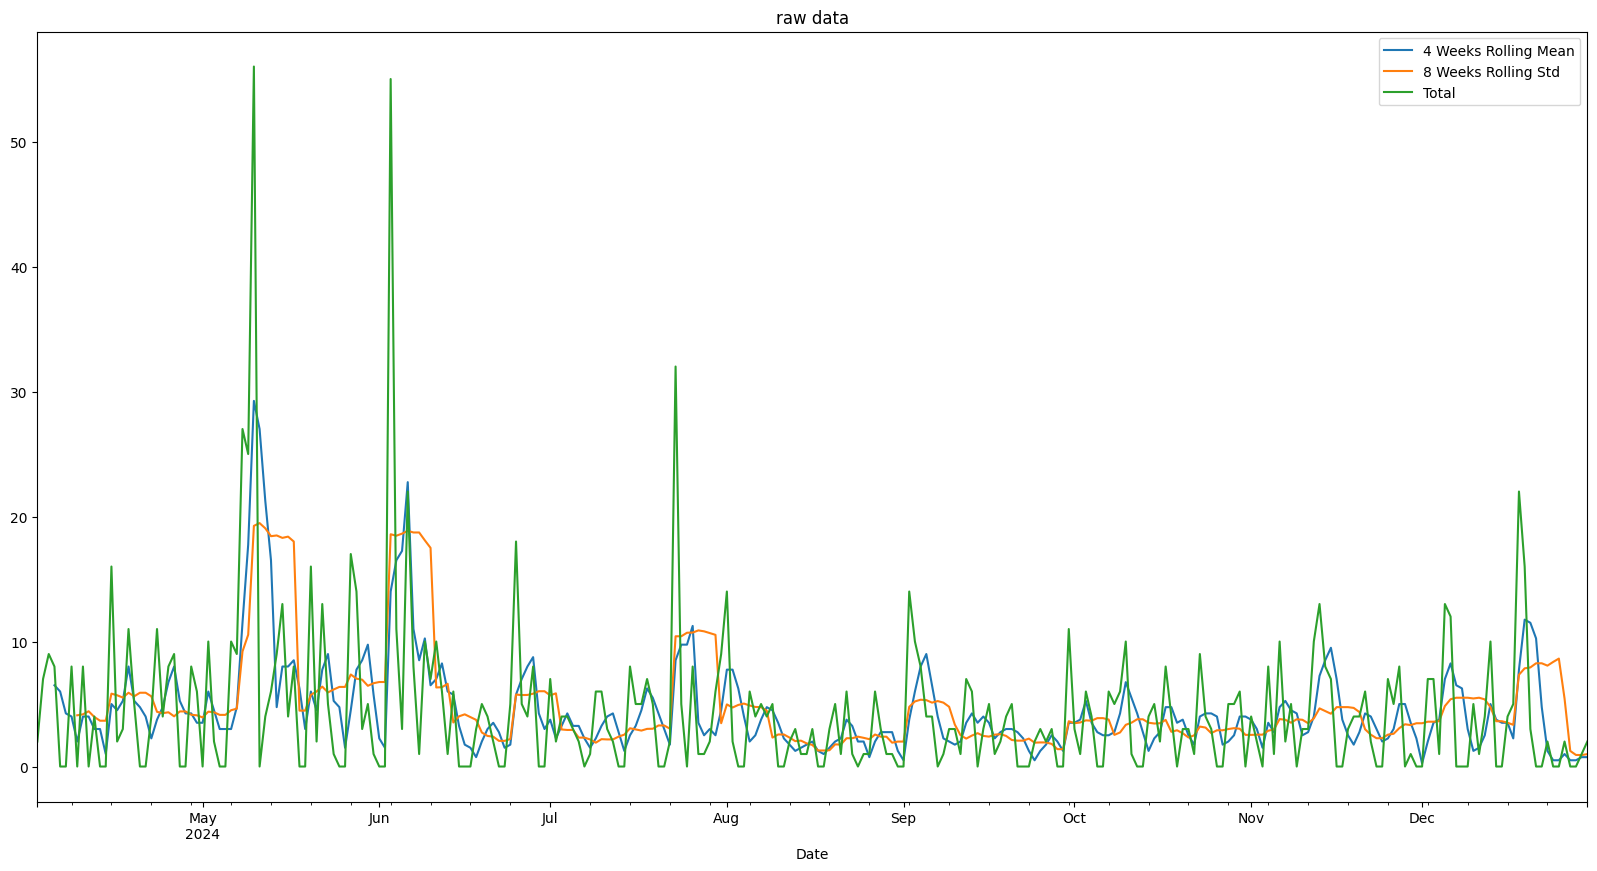

In [57]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(tdf,'raw data')

In [58]:
from statsmodels.tsa.stattools import adfuller

"""
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

    for value,label in zip(test_result,labels):
        print(label)
        print(value)
        #print (value)
    if test_result [1] <= 0.05:
        print ("Reject null hypothesis and data is stationary")
    else:
        print ("Fail to reject H0 thereby data is non-stationary ")
"""
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    test_result = adfuller(timeseries.dropna(),autolag='AIC')
    print ('ADF Test:')
    print('Test statistic = {:.3f}'.format(test_result[0]))
    print('P-value = {:.3f}'.format(test_result[1]))
    print('Critical values :')
    for k, v in test_result[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test_result         [0] else '', 100-int(k[:-1])))

In [59]:
ADF_test(tdf,'raw data')

 > Is the raw data stationary ?
ADF Test:
Test statistic = -4.710
P-value = 0.000
Critical values :
	1%: -3.455365238788105 - The data is  stationary with 99% confidence
	5%: -2.8725510317187024 - The data is  stationary with 95% confidence
	10%: -2.5726375763314966 - The data is  stationary with 90% confidence


In [ ]:
# Detrending
tdf_detrend =  (tdf - tdf.rolling(window=7).mean())/tdf.rolling(window=7).std()
test_stationarity(tdf_detrend,'de-trended data')
ADF_test(tdf_detrend,'de-trended data')

In [ ]:
# Differencing
tdf_4lag =  tdf - tdf.shift(1)

test_stationarity(tdf_4lag,'4 lag differenced data')
ADF_test(tdf_4lag,'4 lag differenced data')

In [ ]:
# Detrending + Differencing
tdf_4lag_detrend =  tdf_detrend - tdf_detrend.shift(4)
test_stationarity(tdf_4lag_detrend,'4 lag differenced de-trended data')
ADF_test(tdf_4lag_detrend,'4 lag differenced de-trended data')

In [60]:
y_to_train = tdf[:'2024-10-01'] # dataset to train
y_to_val = tdf['2024-10-02':] # last X months for test  
#predict_date = len(tdf_4lag) - len(tdf_4lag[:'2024-12-25']) # the number of data points for the test set
#y_to_val.head()
#y_to_train.head()

In [61]:
import itertools

def sarima_grid_search(tdf,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(tdf,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [62]:
sarima_grid_search(tdf,12)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1656.5818787532546


In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(15, 12))
    #results.plot_diagnostics()

    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [ ]:
# No need to run this!!!!
model = sarima_eva(y_to_train,(1, 1, 1),(0, 1, 1, 12),12,'2024-12-31',y_to_val)

In [63]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [64]:
model = sm.tsa.statespace.SARIMAX(y_to_train.dropna(),order=(1,1,1), seasonal_order=(0,1,1,12))
ARIMAresult = model.fit()
print (ARIMAresult.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  183
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -599.108
Date:                            Tue, 11 Mar 2025   AIC                           1206.215
Time:                                    01:02:37   BIC                           1218.758
Sample:                                04-02-2024   HQIC                          1211.305
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1368      0.069      1.983      0.047       0.002       0.272
ma.L1         -0.9616      0.054   

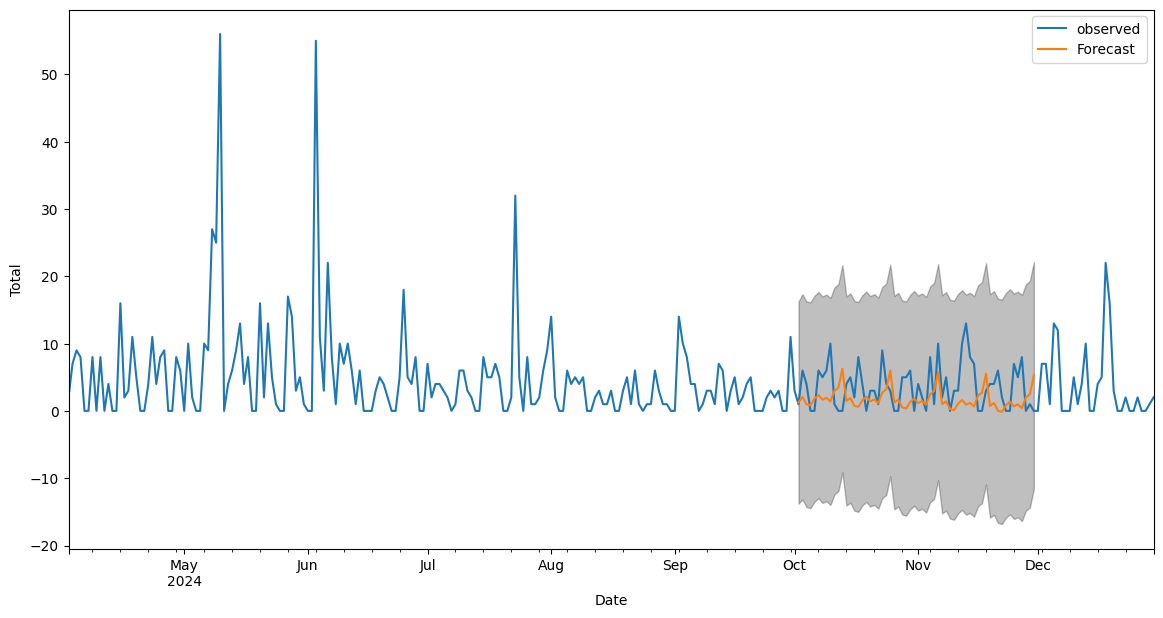

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2024-10-02,1.23807160,-13.77806578,16.25420898
1,2024-10-03,2.08921769,-13.15911746,17.33755283
2,2024-10-04,0.98379980,-14.29376815,16.26136776
3,2024-10-05,0.84256384,-14.45128124,16.13640892
4,2024-10-06,1.80787969,-13.50073360,17.11649298
5,2024-10-07,2.34684816,-12.97632335,17.67001967
6,2024-10-08,1.66559581,-13.67211566,17.00330728
7,2024-10-09,1.93799403,-13.41439998,17.29038804
8,2024-10-10,1.39810909,-13.96984417,16.76606236
9,2024-10-11,2.96529878,-12.40996528,18.34056284


In [66]:
final_table = forecast(ARIMAresult,60,tdf)
final_table.head(15)

In [67]:
PredictionResults = ARIMAresult.predict(1, len(tdf)+2, typ ='levels').rename('Sarima Predictions')
PredictionResults

2024-04-03    1.99992149
2024-04-04    6.99959676
2024-04-05    8.99978780
2024-04-06    8.00004945
2024-04-07    0.00063476
                 ...    
2024-12-29    0.08998752
2024-12-30    0.62881115
2024-12-31   -0.05246102
2025-01-01    0.21993449
2025-01-02   -0.31995082
Freq: D, Name: Sarima Predictions, Length: 275, dtype: float64

In [68]:
from altair import to_csv
PredictionResults.to_csv("PredictionResults.csv")

In [69]:
#df['forecast_data'] = ARIMAresult.predict(start = 150, end= 168, dynamic= True)
#df [['Total','forecast_data']]. plot (figsize= (12,8))
ARIMAtable = pd.Series(ARIMAresult.fittedvalues, copy=True)
ARIMAresult.fittedvalues

Date
2024-04-02   0.00000000
2024-04-03   1.99992149
2024-04-04   6.99959676
2024-04-05   8.99978780
2024-04-06   8.00004945
                ...    
2024-09-27   2.15568490
2024-09-28   1.99231451
2024-09-29   3.25291216
2024-09-30   2.41994449
2024-10-01   8.11842829
Freq: D, Length: 183, dtype: float64

Text(0.5, 1.0, 'RMSE: 5.9873')

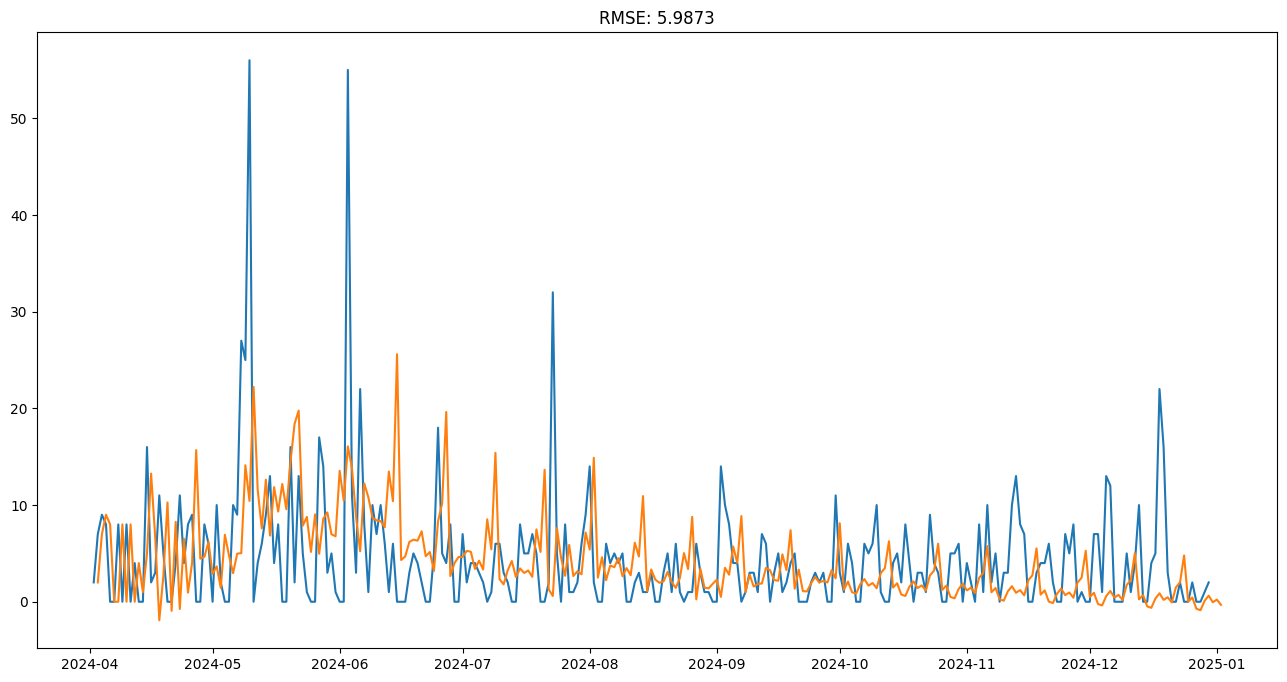

In [70]:
plt.figure(figsize=(16,8))
plt.plot(tdf)
plt.plot(PredictionResults)
plt.title('RMSE: %.4f'% np.sqrt(sum((ARIMAtable)**2)/len(tdf)))

In [ ]:
# Auto ARIMA
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries,
                              start_p = 0,
                              start_q = 0,
                              start_d = 0,
                              max_d = 8,
                              max_p = 8,
                              max_q = 8,
                              test = 'adf',
                              start_P = 0,
                              start_Q = 0,
                              start_D = 0,
                              max_P = 8,
                              max_Q = 8,
                              max_D = 8,
                              stepwise= True,
                              seasonal = True,
                              trace = True,
                              m=12)
    return automodel

In [ ]:
arimamodel(tdf)

In [ ]:
import pickle
pickle.dump(ARIMAresult, open('model.pkl','wb'))

In [83]:
print(pm.auto_arima(tdf.dropna(),seasonal=True, m=12, test = 'adf').summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -895.350
Date:                Tue, 11 Mar 2025   AIC                           1796.701
Time:                        01:07:37   BIC                           1807.529
Sample:                    04-02-2024   HQIC                          1801.048
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6212      0.673      5.382      0.000       2.302       4.940
ar.L1          0.2026      0.032      6.295      0.000       0.139       0.266
sigma2        41.3168      1.506     27.437      0.0

In [ ]:
x = len(tdf)*(80/100)
x

In [72]:
y_to_train = tdf.iloc[:(int)(len(df)*(80/100))]
y_to_val = tdf.iloc[:(int)(len(df)*(20/100))]

In [73]:
model = sm.tsa.statespace.SARIMAX(tdf.dropna(),order=(1,1,1), seasonal_order=(0,1,1,12))

In [74]:
results = model.fit()

In [75]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  273
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -874.658
Date:                            Tue, 11 Mar 2025   AIC                           1757.316
Time:                                    01:04:55   BIC                           1771.558
Sample:                                04-02-2024   HQIC                          1763.041
                                     - 12-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1740      0.043      4.038      0.000       0.090       0.258
ma.L1         -0.9770      0.033   

In [76]:
start = len(y_to_train)

In [77]:
end = start + len(y_to_val) - 1

In [78]:
PredictionResults = results.predict(0, len(tdf)+1, typ ='levels').rename('Sarima Predications')

<Axes: xlabel='Date'>

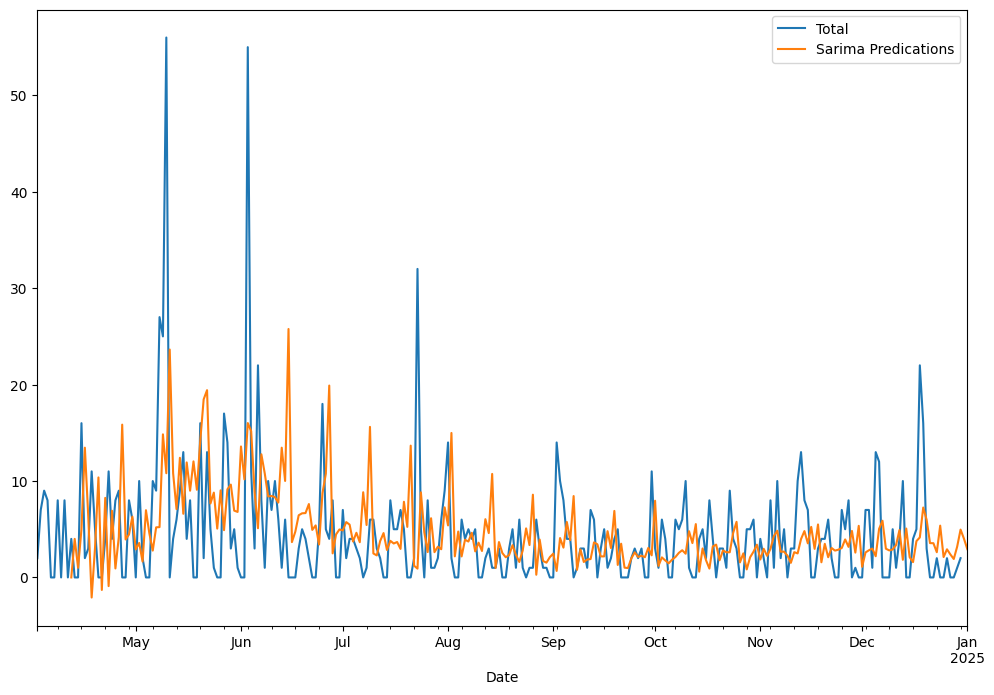

In [79]:
tdf.plot(legend=True,figsize=(12,8))
PredictionResults[10:].plot(legend=True)

In [80]:
from statsmodels.tools.eval_measures import rmse

In [82]:
# Ensure both arrays have the same length by slicing PredictionResults to match y_to_val
error = rmse(y_to_val, PredictionResults[:len(y_to_val)])
error

7.16798650309286